In [ ]:
# 서울 주택 실거래 데이터(최근 5년) 활용 통계분석 및 집값에 영향을 주는 변수 추출하여 예측 모델 생성

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
plt.rcParams["font.family"] = "NanumGothic"
plt.rcParams['axes.unicode_minus'] = False

In [ ]:
# 파일 import 및 dataframe으로 병합
df_list = []
for a in np.arange(2019, 2024):
     df_list.append(pd.read_csv(f'data-files/서울시 부동산 실거래가 정보 {a}.csv', encoding='utf-8'))
seoul_estate = pd.concat(df_list)

In [5]:
# index 조정
seoul_estate.reset_index(inplace=True, drop=True)

# 전처리

In [6]:
# 필요 없는 col 제거
seoul_estate_processed = seoul_estate.drop(columns=['지번구분', '지번구분명', '본번', '부번', '건물명', '계약일', '토지면적(㎡)', '권리구분', '취소일', '신고구분', '신고한 개업공인중개사 시군구명'])

In [8]:
#범주형 데이터 -> LabelEncoder로 숫자 변환 (법정동명, 건물용도)
from sklearn.preprocessing import LabelEncoder #범주 - 이산형 숫자로 변경
le = LabelEncoder()
seoul_estate_processed['법정동명_label'] = le.fit_transform(seoul_estate_processed['법정동명'].values)
seoul_estate_processed['건물용도_label'] = le.fit_transform(seoul_estate_processed['건물용도'].values)

In [9]:
# 자치구코드, 법정동코드 col 제거
seoul_estate_processed.drop(columns=(['자치구코드', '법정동코드']), inplace=True)

In [10]:
#물건금액이 1천억원 이상인 행들 제거 (이상치) (총 4건)
seoul_estate_processed = seoul_estate_processed[seoul_estate_processed['물건금액(만원)'] < 10000000]

In [11]:
# 물건금액 20분위로 label
seoul_estate_processed['물건금액_label'] = pd.qcut(seoul_estate_processed['물건금액(만원)'], q=20, labels=False)

In [12]:
# col name rename
seoul_estate_processed.rename(columns= {'건물면적(㎡)':'건물면적'}, inplace=True)

# 건축년도 NA처리 (오피스텔)

In [13]:
# 건축년도 결측치 (건축년도가 null 이면 해당 건물용도의 median 값을 넣어준다)

# 건물용도별 median 값을 계산하여 딕셔너리에 저장
median_values = seoul_estate_processed.groupby('건물용도')['건축년도'].median().to_dict()

# 건축년도가 null인 경우에 대해 건물용도별 median 값으로 채우기
seoul_estate_processed['건축년도'] = seoul_estate_processed.apply(lambda row: median_values[row['건물용도']] if pd.isna(row['건축년도']) else row['건축년도'], axis=1)

# 층 NA 값 전처리 (단독다가구)

In [14]:
# 층 NA인 값 2층으로 채워주기 (NA 전부 단독다가구임)
seoul_estate_processed['층'].fillna(2,inplace=True)

# INSERT TO DB

In [15]:
seoul_estate[['접수연도', '자치구코드', '법정동코드', '지번구분', '부번',
        '계약일', '물건금액(만원)', '건물면적(㎡)', '토지면적(㎡)', '층', '취소일',
       '건축년도']] = \
seoul_estate[['접수연도', '자치구코드', '법정동코드', '지번구분', '부번',
        '계약일', '물건금액(만원)', '건물면적(㎡)', '토지면적(㎡)', '층', '취소일',
       '건축년도']].fillna(-1)
seoul_estate[['자치구명','법정동명', '지번구분명', '본번','건물명',  '권리구분', '건물용도', '신고구분', '신고한 개업공인중개사 시군구명']]=\
seoul_estate[['자치구명','법정동명', '지번구분명', '본번','건물명',  '권리구분', '건물용도', '신고구분', '신고한 개업공인중개사 시군구명']].fillna("not_available")

In [16]:
import oracledb

In [17]:
# 초기화
oracledb.init_oracle_client()

In [18]:
# 데이터베이스에 연결
conn = oracledb.connect(user="lab02", password="lab02", dsn="127.0.0.1:1521/xe")

In [19]:
seoul_estate_list_fordb = seoul_estate.values.tolist()

In [20]:
# 명령 SQL 실행
cursor = conn.cursor()

for idx, row in enumerate(seoul_estate_list_fordb):
    cursor.execute("""insert into real_estate values(:1, :2, :3, :4, :5, :6, :7, :8, :9, :10, :11, :12, :13, :14, :15, :16, :17, :18, :19, :20, :21)""", row)
    if (idx > 0) and (idx % 100 == 0):
        print(f"{idx + 1} row is processed !!!")

    
cursor.execute("commit")


In [21]:
conn.close()

# 건축년도 0 처리 / 건축년도, 건물면적 10분위 처리

In [22]:
# 건축년도 0 처리
# 건물년도별 median 값을 계산하여 딕셔너리에 저장
median_values = seoul_estate_processed.groupby('건물용도')['건축년도'].median().to_dict()

# 건축년도가 null인 경우에 대해 건물용도별 median 값으로 채우기
seoul_estate_processed['건축년도'] = seoul_estate_processed.apply(lambda row: median_values[row['건물용도']] if row['건축년도'] == 0 else row['건축년도'], axis=1)
# seoul_estate_processed['건축년도'] = seoul_estate_processed.map(lambda row: median_values[row['건물용도']] if row['건축년도'] == 0 else row['건축년도'])

In [23]:
# 건축년도 10분위로 처리
seoul_estate_processed['건축년도_label'] = pd.qcut(seoul_estate_processed['건축년도'], q=10, labels=False)

In [24]:
# 건물면적 10분위로 처리
seoul_estate_processed['건물면적_label'] = pd.qcut(seoul_estate_processed['건물면적'], q=10, labels=False)

# 전체 column 시각화

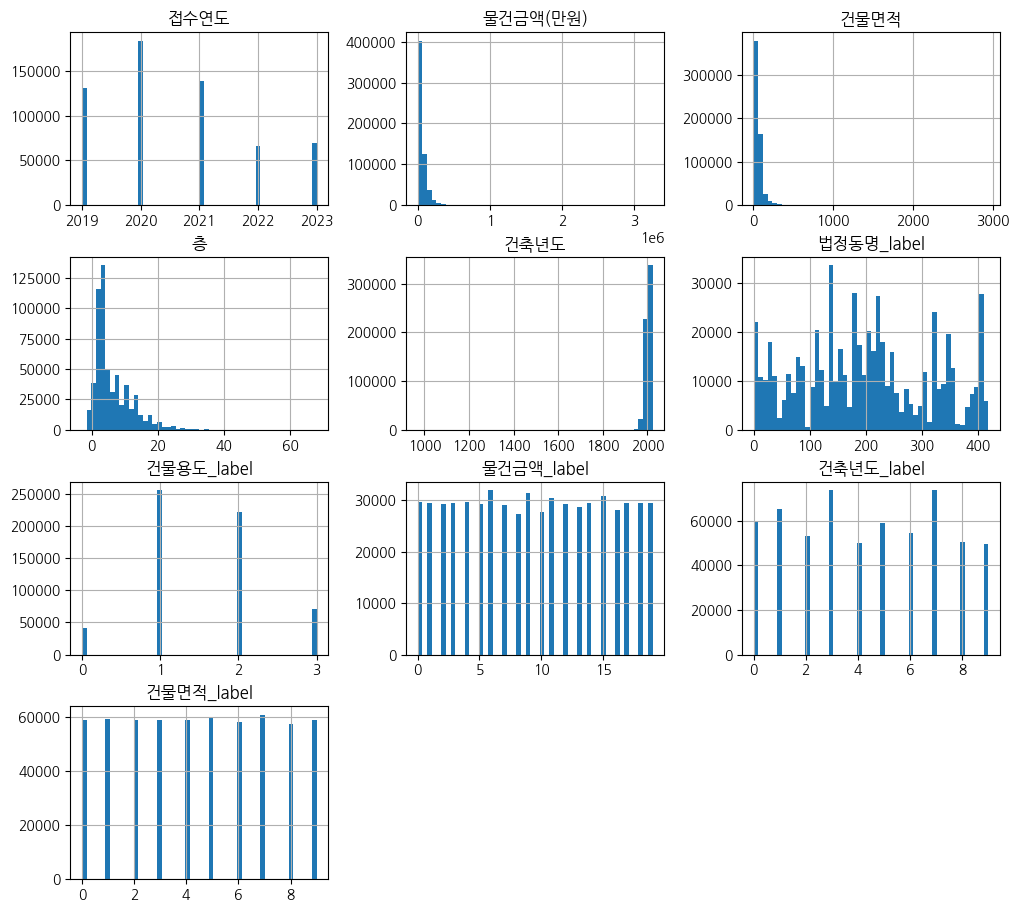

In [25]:
seoul_estate_processed.hist(bins=50, figsize=(12,11))
plt.show()

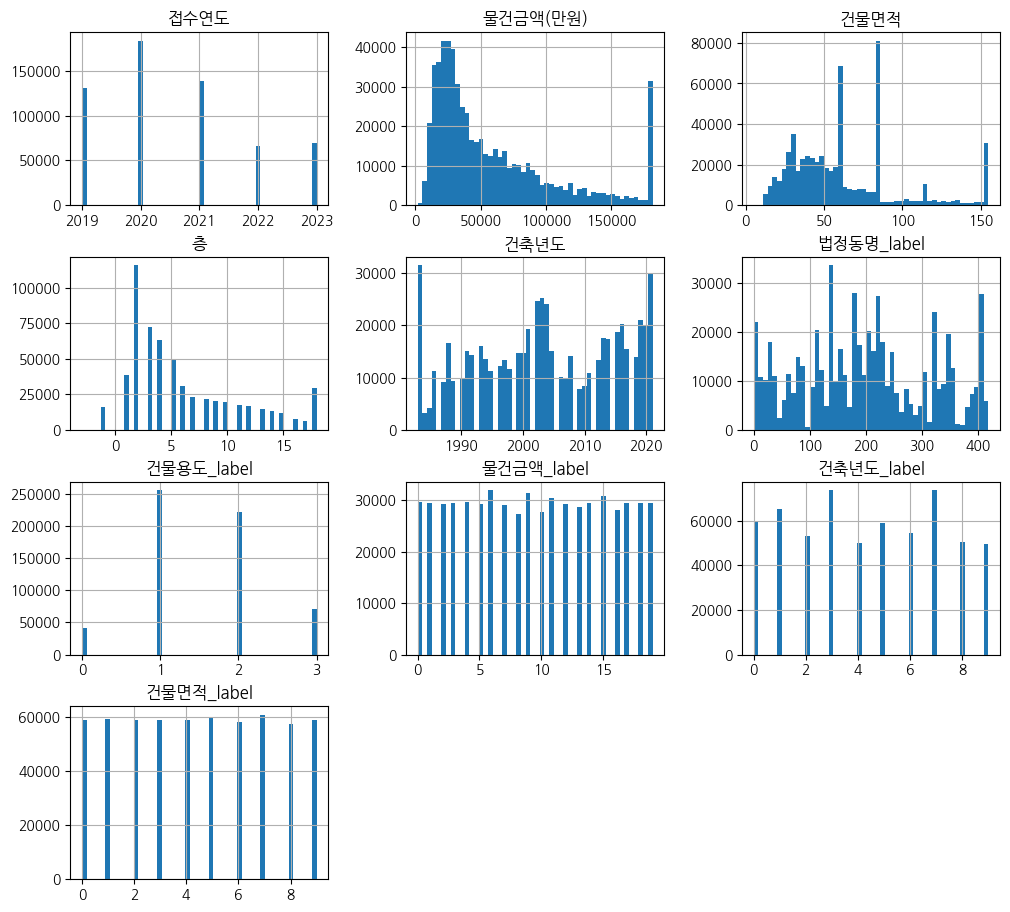

In [30]:
# 스케일링 후 시각화
seoul_estate_processed.hist(bins=50, figsize=(12,11))
plt.show()

# Outlier 처리 (0.95 이상)

In [27]:
print(np.quantile(seoul_estate_processed['층'], q=0.95))
print(np.quantile(seoul_estate_processed['건물면적'], q=0.95))
print(np.quantile(seoul_estate_processed['건축년도'], q=0.95))
print(np.quantile(seoul_estate_processed['물건금액(만원)'], q=0.95))
print(np.quantile(seoul_estate_processed['건축년도'], q=0.05))

18.0
154.9
2021.0
181505.59999999963
1983.0


In [28]:
# 층 결측치 제거
seoul_estate_processed['층'] = seoul_estate_processed.apply(lambda row: 18.0 if row['층'] > 18 else row['층'], axis=1)
seoul_estate_processed['건물면적'] = seoul_estate_processed.apply(lambda row: 155.0 if row['건물면적'] > 155.0 else row['건물면적'], axis=1)
seoul_estate_processed['건축년도'] = seoul_estate_processed.apply(lambda row: 2021.0 if row['건축년도'] > 2021.0 else row['건축년도'], axis=1)
seoul_estate_processed['물건금액(만원)'] = seoul_estate_processed.apply(lambda row: 181505 if row['물건금액(만원)'] > 181505 else row['물건금액(만원)'], axis=1)

In [29]:
seoul_estate_processed['건축년도'] = seoul_estate_processed.apply(lambda row: 1983.0 if row['건축년도'] < 1983.0 else row['건축년도'], axis=1)

In [29]:
seoul_estate_processed.to_pickle('seoul_estate_processed')

# 데이터가 매우 많아(약 60만), feature selection 어려움

# Model

In [32]:
seoul_estate_processed.head(1)

,접수연도,자치구명,법정동명,물건금액(만원),건물면적,층,건축년도,건물용도,법정동명_label,건물용도_label,물건금액_label,건축년도_label,건물면적_label
0,2019,송파구,잠실동,181505,76.5,1.0,1983.0,아파트,321,1,19,0,7


In [33]:
from sklearn.model_selection import train_test_split

X = seoul_estate_processed[['건물면적', '층', '건축년도', '법정동명_label', '건물용도_label']]
y = seoul_estate_processed['물건금액(만원)']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [ ]:
from sklearn.ensemble import RandomForestRegressor
rfc = RandomForestRegressor(n_estimators=1000, random_state=42)
rfc.fit(X_train, y_train)
# rfc.score(X_train, y_train), rfc.score(X_test,y_test)

In [ ]:
import pickle

with open('data-files/team3_rfc.pickle', 'wb') as f:
    pickle.dump(rfc,f)

# 1만 데이터로 test 모델

In [ ]:
# MINMAX SCALE - 건물면적, 건축년도_label, 건물용도_label, 법정동명_label, 물건금액_label, 층
from sklearn.preprocessing import MinMaxScaler

mms = MinMaxScaler()
mms.fit(X_train)
X_scaled_train = mms.transform(X_train)
X_scaled_test = mms.transform(X_test)

X_scaled_train.min(), X_scaled_train.max(), X_scaled_test.min(), X_scaled_test.max()

(0.0, 1.0, 0.0, 1.0)

In [ ]:
from sklearn.model_selection import train_test_split

X_sample = seoul_estate_processed[:10000][['건물면적', '층', '건축년도', '법정동명_label', '건물용도_label']]
y_sample1 = seoul_estate_processed[:10000]['물건금액_label']
y_sample2 = seoul_estate_processed[:10000]['물건금액(만원)']

X_train1, X_test1, y_train1, y_test1 = train_test_split(X_sample, y_sample1, stratify=y_sample1, random_state=42)
X_train2, X_test2, y_train2, y_test2 = train_test_split(X_sample, y_sample2, random_state=42)

In [ ]:
from sklearn.model_selection import train_test_split

X = seoul_estate_processed[['건물면적', '층', '건축년도', '법정동명_label', '건물용도_label']]
y_class = seoul_estate_processed['물건금액_label']
y_regress = seoul_estate_processed['물건금액(만원)']

X_train1, X_test1, y_train1, y_test1 = train_test_split(X, y_class, stratify=y_class, random_state=42)
X_train2, X_test2, y_train2, y_test2 = train_test_split(X, y_regress, random_state=42)

#Classifier
X_sample_train1 = X_train1[:10000]
X_sample_test1 = X_test1[:10000]
y_sample_train1 = y_train1[:10000]
y_sample_test1 = y_test1[:10000]

#Regressor
X_sample_train2 = X_train2[:10000]
X_sample_test2 = X_test2[:10000]
y_sample_train2 = y_train2[:10000]
y_sample_test2 = y_test2[:10000]

In [ ]:
from sklearn.ensemble import RandomForestClassifier #BAD
# maxdepth: default가 가장 좋음
# n_estimator: 늘려도 좋아지지 않음...
# min_samples_split: default
# max_leaf_nodes: default
rfc = RandomForestClassifier(n_estimators=1000, max_depth= 9, random_state=42)
rfc.fit(X_sample_train1, y_sample_train1)
rfc.score(X_sample_train1,y_sample_train1), rfc.score(X_sample_test1,y_sample_test1)

(0.4673, 0.2305)

In [ ]:
from sklearn.ensemble import RandomForestRegressor #GOOD
rfc = RandomForestRegressor(n_estimators=1000, random_state=42)
rfc.fit(X_sample_train2, y_sample_train2)
rfc.score(X_sample_train2,y_sample_train2), rfc.score(X_sample_test2,y_sample_test2)

# (0.9632296976503995, 0.7589186132019898) (n_estimators=1000, random_state=42)

(0.9632296976503995, 0.7589186132019898)

In [ ]:
from sklearn.linear_model import LogisticRegression #BAD
 
#Logistic 분류보델
log = LogisticRegression(max_iter=100000, C=100)
log.fit(X_sample_train1, y_sample_train1)
log.score(X_sample_train1,y_sample_train1), log.score(X_sample_test1,y_sample_test1)

#(0.2844, 0.2713)

(0.1496, 0.1482)

In [ ]:
# rfc = RandomForestRegressor(n_estimators=1000, random_state=42)
# (0.9692654635766125, 0.7753052228227448)
# --> Y를 수치형

# rfc = RandomForestClassifier(n_estimators=1000, random_state=42)
# (0.9965333333333334, 0.5608)
# --> Y를 범주형



# rfc = RandomForestClassifier(n_estimators=1000, random_state=42)
# (0.9542666666666667, 0.4828)
# --> Y를 범주형 / 전부 다 Label 데이터 사용


# rfc = RandomForestClassifier(n_estimators=100, random_state=42)
# (0.9880888888888889, 0.6221333333333333)

# rfc = RandomForestClassifier(n_estimators=100, random_state=42)
# (0.8733635129017655, 0.568355436044735)
# -->전체 데이터 사용

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor

gbc = GradientBoostingRegressor(n_estimators=1000, random_state=42)
gbc.fit(X_scaled_train, y_train)
gbc.score(X_scaled_train, y_train), gbc.score(X_scaled_train, y_test)

(0.9534666666666667, 0.5776)

In [ ]:
# rfc = RandomForestClassifier(n_estimators=1000, random_state=42)
# (0.9972, 0.5628)

# rfc = RandomForestClassifier(n_estimators=10000, random_state=42)
# (0.9966666666666667, 0.5636)

# rfc = RandomForestRegressor(n_estimators=1000, random_state=42)
# (0.9692654635766125, 0.7753052228227448)

In [ ]:
# Scale이 안 한 것으로 /-> 스케일 조정 필요!
from sklearn.svm import SVC, LinearSVC
svc = SVC(C= 1, random_state=42)
svc.fit(X_scaled_train, y_train)
svc.score(X_scaled_train, y_train), svc.score(X_scaled_test, y_test)

(0.06946666666666666, 0.0588)

# 통계치 / 시각화

In [33]:
seoul_estate_processed.info()

<class 'pandas.core.frame.DataFrame'>
Index: 589067 entries, 0 to 589070
Data columns (total 13 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   접수연도        589067 non-null  int64  
 1   자치구명        589067 non-null  object 
 2   법정동명        589067 non-null  object 
 3   물건금액(만원)    589067 non-null  int64  
 4   건물면적        589067 non-null  float64
 5   층           589067 non-null  float64
 6   건축년도        589067 non-null  float64
 7   건물용도        589067 non-null  object 
 8   법정동명_label  589067 non-null  int32  
 9   건물용도_label  589067 non-null  int32  
 10  물건금액_label  589067 non-null  int64  
 11  건축년도_label  589067 non-null  int64  
 12  건물면적_label  589067 non-null  int64  
dtypes: float64(3), int32(2), int64(5), object(3)
memory usage: 58.4+ MB


In [ ]:
# 기본 범주 데이터 산점도 그래프
tips = sns.load_dataset("tips")
sns.catplot(x="day", y="total_bill", hue="sex", kind="swarm", data=tips)
plt.show()
# jitter : easing overplotting


In [31]:
seoul_estate_processed

,접수연도,자치구명,법정동명,물건금액(만원),건물면적,층,건축년도,건물용도,법정동명_label,건물용도_label,물건금액_label,건축년도_label,건물면적_label
0,2019,송파구,잠실동,181505,76.50,1.0,1983.0,아파트,321,1,19,0,7
1,2019,도봉구,도봉동,13100,36.32,1.0,1987.0,연립다세대,83,2,1,0,2
2,2019,송파구,잠실동,181505,84.80,14.0,2008.0,아파트,321,1,19,6,7
3,2019,성북구,석관동,53200,91.67,2.0,1983.0,단독다가구,190,0,12,0,8
4,2019,강서구,등촌동,25000,57.76,9.0,2005.0,오피스텔,108,3,5,5,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...
589066,2023,강서구,공항동,36800,29.47,6.0,2015.0,연립다세대,19,2,9,7,1
589067,2023,은평구,신사동,73500,84.96,9.0,2006.0,아파트,221,1,14,5,8
589068,2023,마포구,성산동,15500,16.36,13.0,2018.0,오피스텔,195,3,1,8,0
589069,2023,양천구,신월동,17800,70.09,2.0,1983.0,단독다가구,226,0,2,0,6


In [ ]:
# 물건금액(y), 건물면적(x) paired sample t-test
from scipy import stats
price, area = seoul_estate_processed['물건금액(만원)'].values, seoul_estate_processed['건물면적'].values
stats.ttest_rel(price, area)

TtestResult(statistic=952.9549572044103, pvalue=0.0, df=589066)

In [ ]:
# 건물용도(x), 건축년도(x) paired sample t-test
from scipy import stats
price, area = seoul_estate_processed['건물용도_label'].values, seoul_estate_processed['건축년도'].values
stats.ttest_rel(price, area)

TtestResult(statistic=-137961.3366006024, pvalue=0.0, df=589066)

In [ ]:
corr_table = seoul_estate_processed[['물건금액(만원)', '건물면적', '층', '건축년도']].corr()

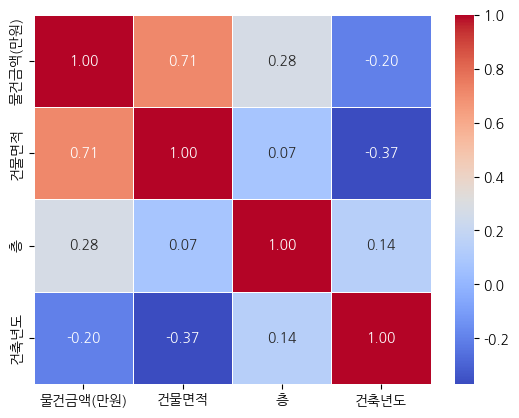

In [ ]:
# 수치형 데이터들 간 상관계수
import seaborn as sns
sns.heatmap(corr_table, annot=True, cmap='coolwarm', fmt='.2f', linewidths=.5)
plt.show()

# 자치구별 평균 물건금액(만원) 및 건물용도

In [ ]:
price_by_area = seoul_estate_processed.groupby(['자치구명', '건물용도'])['물건금액(만원)'].mean().sort_values().reset_index()

In [ ]:
price_by_area['건물용도'] = price_by_area['건물용도'].astype('category')

In [ ]:
order_list = price_by_area.groupby('자치구명')['물건금액(만원)'].mean().sort_values().index

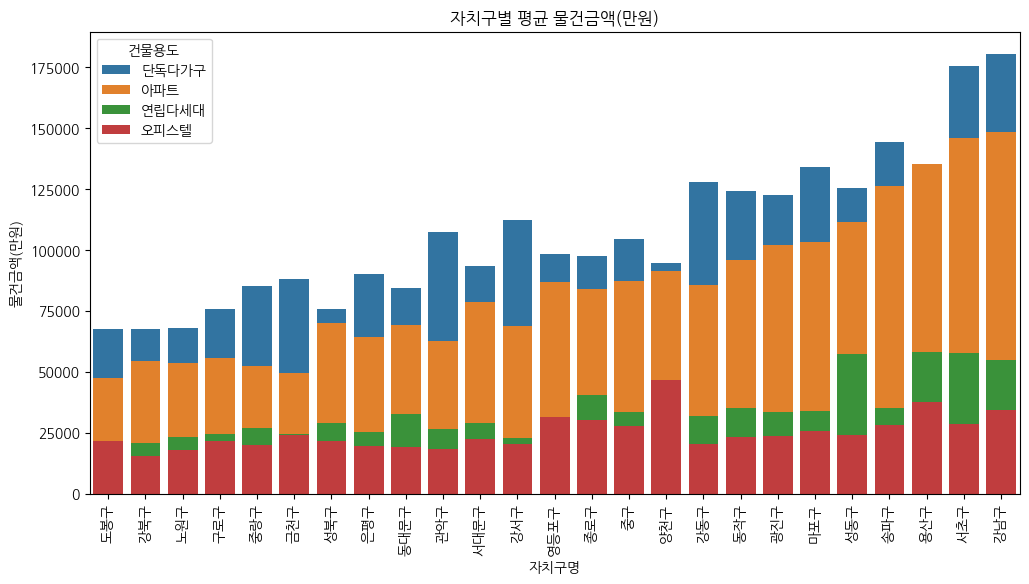

In [ ]:
plt.figure(figsize=(12,6))
# custom_palette = sns.color_palette("husl", n_colors=len(price_by_area['건물용도'].unique()))
sns.barplot(x='자치구명', y='물건금액(만원)', hue='건물용도', order=order_list, dodge=False, data=price_by_area)
plt.xticks(rotation=90)
plt.title('자치구별 평균 물건금액(만원)')
plt.show()

In [ ]:
price_by_floor = price_by_floor[2:]
price_by_floor.reset_index(drop=True,inplace=True)

C:\Users\geon0\AppData\Local\Temp\ipykernel_37224\3542415945.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  price_by_floor = seoul_estate_processed.groupby('층')['물건금액(만원)'].mean().reset_index()


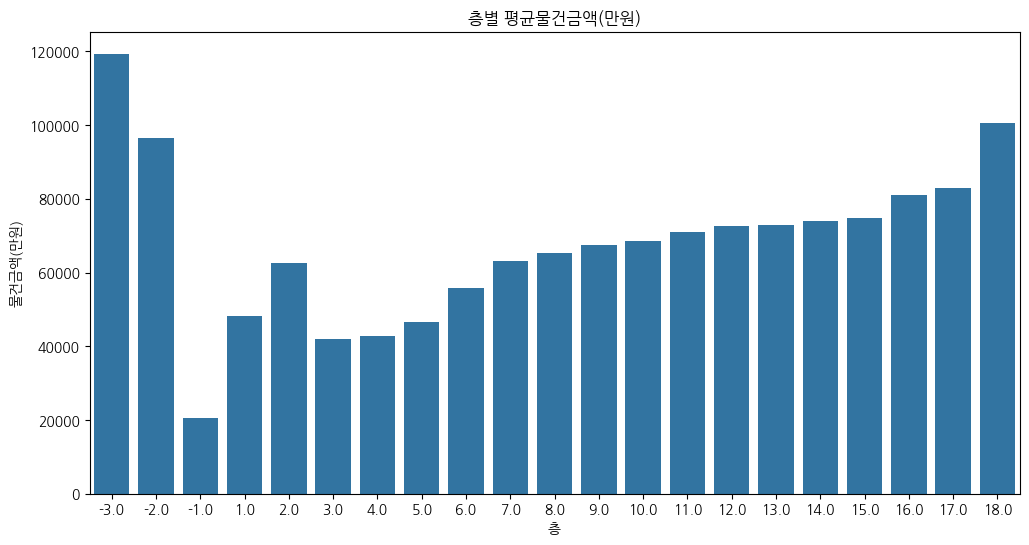

In [ ]:
# Convert '층' to a categorical variable
seoul_estate_processed['층'] = seoul_estate_processed['층'].astype('category')

# Calculate the average price for each floor
price_by_floor = seoul_estate_processed.groupby('층')['물건금액(만원)'].mean().reset_index()

# Bar Plot with specified color palette and order
plt.figure(figsize=(12, 6))
sns.barplot(x='층', y='물건금액(만원)', data=price_by_floor)
plt.xticks(rotation=0)  # You can adjust the rotation if needed
plt.title('층별 평균물건금액(만원)')
plt.show()


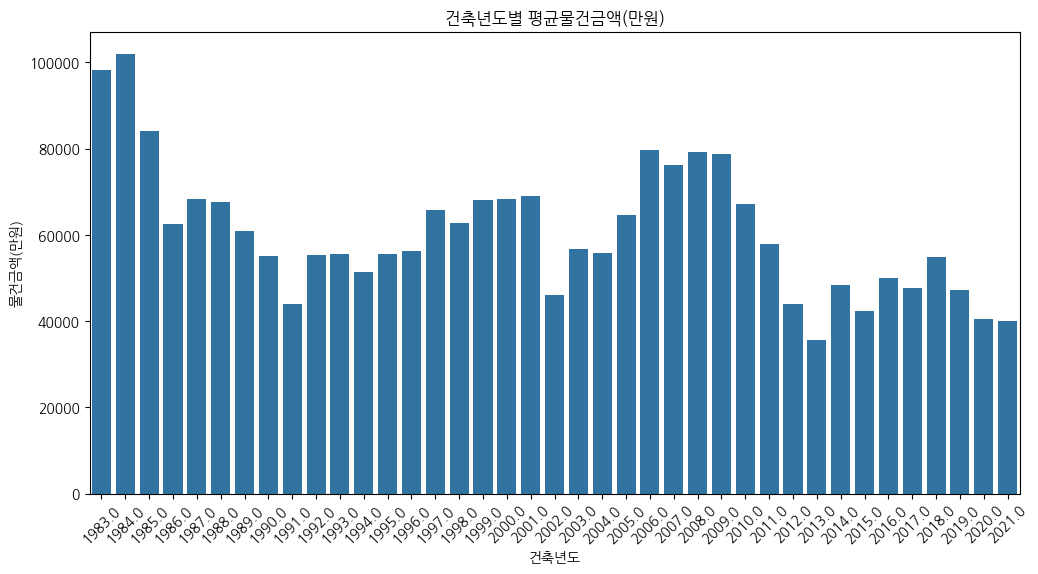

In [ ]:
# Convert '층' to a categorical variable
# seoul_estate_processed['층'] = seoul_estate_processed['층'].astype('category')

# Calculate the average price for each floor
price_by_year = seoul_estate_processed.groupby('건축년도')['물건금액(만원)'].mean().reset_index()

# Bar Plot with specified color palette and order
plt.figure(figsize=(12, 6))
sns.barplot(x='건축년도', y='물건금액(만원)', data=price_by_year)
plt.xticks(rotation=45)  # You can adjust the rotation if needed
plt.title('건축년도별 평균물건금액(만원)')
plt.show()
